# Airbnb Rio de Janeiro - Regressão lognormal

# 1. Introdução

Esse notebook propõe aplicar um modelo de Regressão Lognormal para os [dados do Airbnb na cidade do Rio de Janeiro](https://insideairbnb.com/get-the-data/#:~:text=Rio%20de%20Janeiro%2C%20Rio%20de%20Janeiro%2C%20Brazil). 

Os dados são carregados do processo de [feature engineering](https://github.com/BPRateiro/rio-airbnb-data-analysis/blob/main/notebooks/feature_engineering.ipynb).Incluem informações detalhadas sobre a disponibilidade de listagens, características dos imóveis, interações de usuários, e preços. 

O objetivo principal é construir um modelo que preserva sua interpretabilidade.

## 1.1 Configurações e bibliotecas

In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.genmod.families import Gamma, links
from scipy.stats import gamma, kstest, norm
import matplotlib.pyplot as plt
from distfit import distfit
import numpy as np

## 1.2 Leitura dos dados

In [2]:
df_inicial = pd.read_parquet('../data/silver/feature_engineering_output.parquet')
df_inicial.drop(columns=[col for col in df_inicial.columns if df_inicial[col].nunique() == 1], inplace=True)
df_inicial.head()

,accommodates,availability_365,availability_60,bathrooms,bedrooms,beds,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,days_since_first_review,...,review_scores_value,reviews_per_month,verification_email,verification_work_email,was_reviewed,host_response_time_within_a_day,host_response_time_within_a_few_hours,host_response_time_within_an_hour,room_type_others,room_type_private_room
0,5.0,269.0,59.0,2.0,1.0,2.0,1.0,0.0,0.0,131.8,...,4.502,1.700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,176.0,56.0,2.0,2.0,0.0,6.0,0.0,0.0,173.0,...,4.500,0.690,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,2.0,267.0,59.0,1.0,1.0,1.0,0.0,2.0,0.0,151.4,...,4.600,0.448,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,2.0,38.0,35.0,1.0,1.0,1.0,1.0,1.0,0.0,531.0,...,5.000,0.230,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,5.0,10.0,10.0,2.0,2.0,3.0,1.0,0.0,0.0,3631.0,...,4.740,3.040,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


# 2. Modelos de regressão gama

Abaixo, apresentamos os modelos de regressão gama que utilizamos para prever o valor do aluguel de uma casa.

## 2.1 Modelo de Baseline

Embora no EDA vimos que a distribuição mais adequada para a variável resposta `price` fosse a Gen Extreme, por razões de uma maior facilidade ao modelar e interpretar os resultados do modelo, optamos aqui por modelar nossos dados com uma distribuição Gama.

O modelo de baseline corresponde ao ajuste da média à todo e qualquer ponto da distribuição. Portanto, o modelo de baseline consiste ao intercepto, sem considerar outras variáveis explicativas.

In [3]:
# Primeiro, adicionamos uma constante para representar o intercepto
X_baseline = sm.add_constant(np.ones(df_inicial.shape[0]))  # Apenas o intercepto
y = df_inicial['price']

# Ajustar o modelo GLM com distribuição Gama e função de ligação log
gamma_model = sm.GLM(y, X_baseline, family=sm.families.Gamma(link=sm.families.links.Log()))
gamma_result = gamma_model.fit()

# Resumo do modelo ajustado
gamma_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  price   No. Observations:                24255
Model:                            GLM   Df Residuals:                    24254
Model Family:                   Gamma   Df Model:                            0
Link Function:                    Log   Scale:                         0.43221
Method:                          IRLS   Log-Likelihood:            -1.6193e+05
Date:                Mon, 26 Aug 2024   Deviance:                       9770.7
Time:                        18:48:35   Pearson chi2:                 1.05e+04
No. Iterations:                     7   Pseudo R-squ. (CS):              0.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8762      0.004   1392.028      0.000       5.868       5.884
==============================================================================
"""

## 2.2 Modelo saturado

Ajustamos um modelo contendo todas as variáveis explicativas do dataset. Chegamos à um modelo com uma melhora substancial com relação à baseline. O parâmetro pseudo R² indica que o modelo inicial foi capaz de explicar aproximadamente 53% da variância dos dados.

Um passo natural para melhorar o modelo é a seleção de variáveis. Porém, precisamos primeiramente avaliar as premissas do modelo.

In [4]:
# Seleção de algumas variáveis explicativas para o modelo
X = df_inicial.drop(columns=['price'])

# Adicionar uma constante para o intercepto
X = sm.add_constant(X)

# Ajustar o modelo GLM com as variáveis explicativas selecionadas
modelo_inicial = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.Log())).fit()

# Resumo do modelo ajustado
modelo_inicial.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  price   No. Observations:                24255
Model:                            GLM   Df Residuals:                    24211
Model Family:                   Gamma   Df Model:                           43
Link Function:                    Log   Scale:                         0.25149
Method:                          IRLS   Log-Likelihood:            -1.5395e+05
Date:                Mon, 26 Aug 2024   Deviance:                       5154.1
Time:                        18:48:36   Pearson chi2:                 6.09e+03
No. Iterations:                    23   Pseudo R-squ. (CS):             0.5308
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                          -65.4302      2.291    -28.561      0.000     -69.920     -60.940
accommodates                                     0.0475      0.002     19.274      0.000       0.043       0.052
availability_365                                 0.0004   3.32e-05     11.206      0.000       0.000       0.000
availability_60                                  0.0009      0.000      4.746      0.000       0.001       0.001
bathrooms                                        0.1057      0.006     18.275      0.000       0.094       0.117
bedrooms                                         0.1641      0.005     31.183      0.000       0.154       0.174
beds                                            -0.0192      0.002     -7.795      0.000      -0.024      -0.014
calculated_host_listings_count_entire_homes      0.0001      0.000      0.569      0.569      -0.000       0.000
calculated_host_listings_count_private_rooms     0.0012      0.002      0.609      0.543      -0.003       0.005
calculated_host_listings_count_shared_rooms     -0.0283      0.004     -6.912      0.000      -0.036      -0.020
days_since_first_review                      -4.814e-05   5.21e-06     -9.239      0.000   -5.84e-05   -3.79e-05
days_since_host_active                        2.101e-05   3.13e-06      6.712      0.000    1.49e-05    2.71e-05
days_since_last_review                           0.0002   1.05e-05     19.442      0.000       0.000       0.000
description_length                           -5.651e-06   2.16e-05     -0.261      0.794   -4.81e-05    3.68e-05
host_about_length                            -5.064e-05   1.15e-05     -4.417      0.000   -7.31e-05   -2.82e-05
host_acceptance_rate                             0.0362      0.015      2.384      0.017       0.006       0.066
host_identity_verified                          -0.0010      0.009     -0.111      0.912      -0.019       0.017
host_is_superhost                                0.0315      0.008      3.822      0.000       0.015       0.048
host_listings_count                              0.0002   4.53e-05      5.412      0.000       0.000       0.000
host_responded                                  -0.3694      0.016    -23.141      0.000      -0.401      -0.338
instant_bookable                                 0.0450      0.009      5.271      0.000       0.028       0.062
latitude                                        -4.7681      0.104    -45.775      0.000      -4.972      -4.564
longitude                                        0.9097      0.038     24.160      0.000       0.836       0.984
maximum_nights                               -3.832e-05   8.16e-06     -4.695      0.000   -5.43e-05   -2.23e-05
minimum_nights                  

# 2.3 Avaliação das premissas

Aplicando um teste de Kolmogorov-Smirnov (KS) aos resíduos, podemos observar:
- `KS Statistic (0.03)`: mede a diferença máxima entre a distribuição dos resíduos e a distribuição gama ajustada. O valor próximo de 0 indica que as distribuições são semelhantes.
- `p-value (1.17e-16):`  um valor baixo de p-value sugere que há uma diferença estatisticamente significativa entre os resíduos e a distribuição gama. Isso implica que os resíduos provavelmente não seguem a distribuição gama ajustada.

Apesar do valor da estatística KS ser baixo, o p-valor sugere que temos evidência que a hipótese nula deve ser rejeitada, ou seja, os resíduos não seguem uma distribuição gama ajustada.

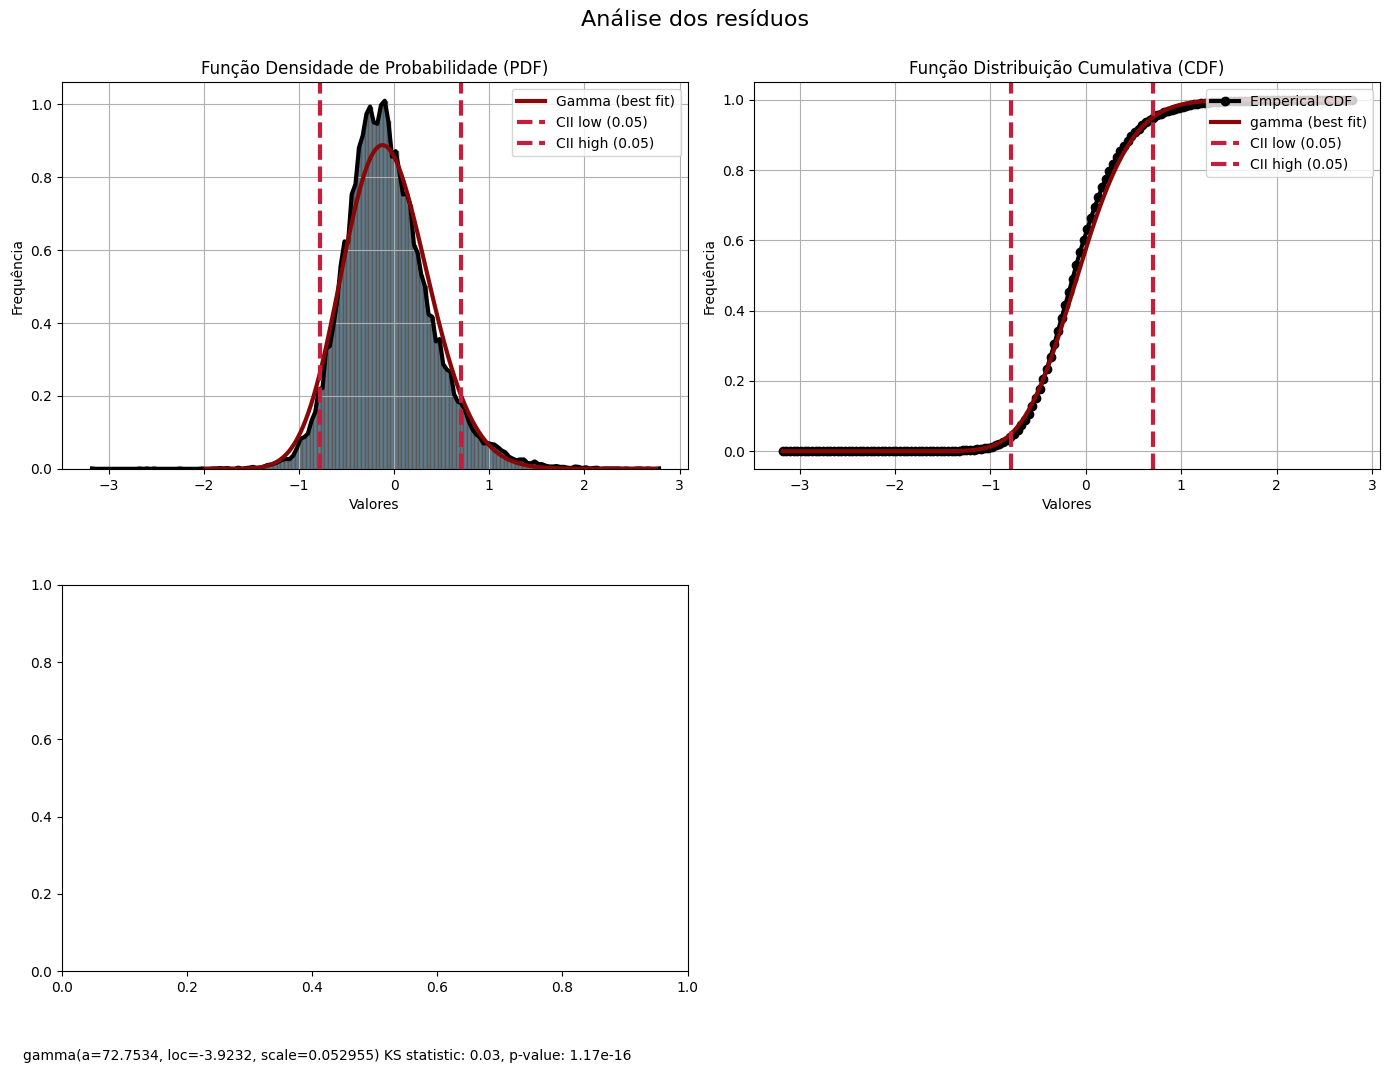

In [5]:
# Ajustar a distribuição gama aos resíduos
residuals = modelo_inicial.resid_deviance
dfit = distfit(distr='gamma')
result = dfit.fit_transform(residuals, verbose=False)
dfit.bootstrap(X=residuals, n_boots=100, alpha=0.05, n=10_000, update_model=True)

# Realizar o teste KS
ks_stat, p_value = kstest(residuals, 'gamma', args=result['model']['params'])

# Criar os subgráficos
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Análise dos resíduos", fontsize=16, y=1)

# Plotar PDF e CDF com títulos personalizados
dfit.plot(chart='pdf', ax=axs[0, 0])
dfit.plot(chart='cdf', ax=axs[0, 1])
axs[0, 0].set_title('Função Densidade de Probabilidade (PDF)', fontsize=12)
axs[0, 1].set_title('Função Distribuição Cumulativa (CDF)', fontsize=12)

# Configurar o tamanho dos labels dos eixos e tick labels
for ax in axs[0, :]:
    ax.set_xlabel('Valores', fontsize=10)
    ax.set_ylabel('Frequência', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=10)

# Deixar o último subplot inferior em branco
axs[1, 1].axis('off')

# Legenda
plt.figtext(0.02, -0.05, 
            (f"gamma(a={result['model']['params'][0]:.4f}, "
             f"loc={result['model']['params'][1]:.4f}, "
             f"scale={result['model']['params'][2]:.6f}) "
             f"KS statistic: {ks_stat:.2f}, p-value: {p_value:.2e}"),
            wrap=True, horizontalalignment='left', fontsize=10)

# Ajustar layout e exibir os gráficos
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.show()

In [7]:
def envel_gama(modelo, X, ax=None):
    """
    Baseado na função envel_gama em R do professor Gilberto de Paula
    Link: https://www.ime.usp.br/~giapaula/envel_gama
    """
    n = X.shape[0]  # Número de observações no conjunto de dados
    p = X.shape[1]  # Número de parâmetros (incluindo o intercepto)
    fitted_values = modelo.fittedvalues  # Valores ajustados pelo modelo
    mu = fitted_values  # Média ajustada
    var_func = modelo.family.variance  # Função de variância da família Gamma
    
    # Cálculo dos pesos (para modelos GLM, os pesos podem ser derivados da função de variância)
    weights = 1 / var_func(mu)  # Pesos são o inverso da variância da média ajustada
    sqrt_W = np.sqrt(weights.to_numpy())  # Converte para numpy e calcula a raiz quadrada dos pesos
    
    # Ajusta as dimensões para a multiplicação
    X_np = X.to_numpy()  # Converter X para NumPy explicitamente
    WX = X_np * sqrt_W[:, np.newaxis]  # Multiplicação de W^(1/2) pela matriz X
    H = np.linalg.solve(WX.T @ WX, np.eye(p))  # Cálculo da matriz de projeção
    H = WX @ H @ WX.T  # Matriz H, usada para calcular a alavancagem
    h = np.diag(H)  # Alavancagem de cada observação (elementos diagonais de H)
    
    # Resíduos de deviância padronizados
    ro = modelo.resid_response  # Resíduos do tipo "response" (diferença entre observado e ajustado)
    fi = (n - p) / np.sum((ro / mu) ** 2)  # Estimativa do parâmetro de dispersão (phi)
    td = modelo.resid_deviance * np.sqrt(fi / (1 - h))  # Resíduos deviance padronizados
    
    # Geração de resíduos simulados
    e = np.zeros((n, 100))  # Matriz para armazenar os resíduos simulados
    for i in range(100):
        # Geração de respostas simuladas usando a distribuição gama
        resp_sim = gamma.rvs(a=fi, size=n)
        resp_sim = (fitted_values / fi) * resp_sim  # Ajuste para que as respostas simuladas tenham média adequada
        modelo_sim = sm.GLM(resp_sim, X_np, family=sm.families.Gamma(link=sm.families.links.Log())).fit()  # Ajuste do modelo simulador
        
        mu_sim = modelo_sim.fittedvalues  # Valores ajustados do modelo simulado
        weights_sim = 1 / var_func(mu_sim)  # Pesos simulados
        sqrt_W_sim = np.sqrt(weights_sim.to_numpy())  # Converte para numpy e calcula a raiz quadrada dos pesos simulados
        
        WX_sim = X_np * sqrt_W_sim[:, np.newaxis]  # Multiplicação de W^(1/2) simulada pela matriz X
        H_sim = np.linalg.solve(WX_sim.T @ WX_sim, np.eye(p))  # Cálculo da matriz de projeção para o modelo simulador
        H_sim = WX_sim @ H_sim @ WX_sim.T  # Matriz H simulada
        h_sim = np.diag(H_sim)  # Alavancagem simulada
        
        ro_sim = modelo_sim.resid_response  # Resíduos simulados do tipo "response"
        phi_sim = (n - p) / np.sum((ro_sim / mu_sim) ** 2)  # Estimativa de dispersão simulada
        e[:, i] = np.sort(modelo_sim.resid_deviance * np.sqrt(phi_sim / (1 - h_sim)))  # Resíduos deviance padronizados simulados, ordenados
    
    # Cálculo dos quantis
    e1 = np.mean(e[1:3, :], axis=0)  # Aproximação do percentil inferior (2,5%) dos resíduos simulados
    e2 = np.mean(e[-3:-1, :], axis=0)  # Aproximação do percentil superior (97,5%) dos resíduos simulados
    med = np.mean(e, axis=1)  # Média dos resíduos simulados (linha média do envelope)
    
    # Cria uma nova figura e eixo se nenhum for fornecido
    if ax is None: 
        fig, ax = plt.subplots(figsize=(8, 8))  
        show_fig = True 
    else:
        show_fig = False
    
    faixa = np.array([np.min([td.min(), e1.min(), e2.min()]), np.max([td.max(), e1.max(), e2.max()])])  # Faixa de valores para o eixo y
    
    # Plotar os resíduos observados
    sm.qqplot(td, line ='45', ax=ax)
    ax.set_xlim(faixa)
    ax.set_ylim(faixa)
    ax.set_title("Envelope Gama para Resíduos Deviance Padronizados")
    
    # Plotar os envelopes
    ax.plot(np.sort(td), np.sort(e1), 'r--', label="Envelope Inferior")
    ax.plot(np.sort(td), np.sort(e2), 'r--', label="Envelope Superior")
    ax.plot(np.sort(td), np.sort(med), 'g-', label="Média Simulada")
    ax.set_xlabel("Percentil da N(0,1)") 
    ax.set_ylabel("Componente do Desvio")
    ax.legend()
    
    if show_fig:
        plt.show()  # Mostra a figura se nenhum eixo foi fornecido
    
    return ax  # Retorna o objeto ax

envel_gama(modelo_inicial, X)

MemoryError: Unable to allocate 4.38 GiB for an array with shape (24255, 24255) and data type float64

# 3. Forward Selection

Uma vez que a seleção de variáveis não é adequada para o modelo saturado, pois esse não se ajusta adequadamente à distribuição selecionada, optamos por um método de seleção automática de variáveis, o [forward selection](https://planspace.org/20150423-forward_selection_with_statsmodels/).

In [7]:
def forward_selected(data, response, family):
    """Seleção stepwise (forward) para modelos GLM, usando AIC como critério."""
    
    # Define o conjunto de variáveis preditoras ainda não selecionadas
    remaining = set(data.columns)
    remaining.remove(response)
    
    # Lista de variáveis selecionadas para o modelo
    selected = []
    
    # Inicializa as variáveis para armazenar a melhor pontuação atual e nova
    current_score, best_new_score = float('inf'), float('inf')
    
    # Continua o processo enquanto houver variáveis a serem testadas e o modelo estiver melhorando
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        
        # Testa cada variável restante
        for candidate in remaining:
            # Cria a fórmula do modelo com a variável candidata incluída
            formula = "{} ~ {} + 1".format(response, ' + '.join(selected + [candidate]))
            
            # Ajusta o modelo GLM e calcula o AIC
            model = smf.glm(formula, data, family=family).fit()
            score = model.aic
            
            # Armazena a pontuação e a variável candidata
            scores_with_candidates.append((score, candidate))
        
        # Ordena os resultados com base no AIC e seleciona o melhor
        scores_with_candidates.sort(reverse=True)
        best_new_score, best_candidate = scores_with_candidates.pop()
        
        # Se o novo modelo for melhor, atualiza a lista de variáveis selecionadas
        if current_score > best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    
    # Ajusta o modelo final com as variáveis selecionadas
    formula = "{} ~ {} + 1".format(response, ' + '.join(selected))
    model = smf.glm(formula, data, family=family).fit()
    
    # Retorna o modelo final ajustado
    return model

modelo_otimizado = forward_selected(df_inicial, response='price', family=sm.families.Gamma(link=sm.families.links.Log()))
summary = modelo_otimizado.summary()

# 4. Interpretação dos resultados

| Variável                                      | Coeficiente  | Transformação [exp(coef) - 1]  | Interpretação                                 |
|-----------------------------------------------|--------------|-------------------------------------------|-----------------------------------------------|
| longitude                                     | 0.9072       | 147.7%                                    | Aumento de 147.7% no preço para cada unidade de aumento na longitude. |
| Intercept                                     | -65.5404     | -100%                                     | Base log do preço quando todas as variáveis são zero. |
| latitude                                      | -4.7683      | -99.2%                                    | Redução de 99.2% no preço para cada unidade de aumento na latitude. |
| room_type_others                              | -0.5733      | -43.6%                                    | Redução de 43.6% no preço para outros tipos de quartos. |
| host_responded                                | -0.3634      | -30.5%                                    | Redução de 30.5% no preço se o anfitrião respondeu. |
| room_type_private_room                        | -0.3127      | -26.8%                                    | Redução de 26.8% no preço para quartos privados. |
| was_reviewed                                  | -0.2251      | -20.1%                                    | Redução de 20.1% no preço se o imóvel foi avaliado. |
| review_scores_location                        | 0.1693       | 18.5%                                     | Aumento de 18.5% no preço para cada ponto adicional na pontuação de localização. |
| review_scores_value                           | -0.1998      | -18.1%                                    | Redução de 18.1% no preço para cada ponto adicional na pontuação de valor. |
| bedrooms                                      | 0.1641       | 17.8%                                     | Aumento de 17.8% no preço para cada quarto adicional. |
| review_scores_rating                          | 0.1526       | 16.5%                                     | Aumento de 16.5% no preço para cada ponto adicional na pontuação geral. |
| bathrooms                                     | 0.1057       | 11.1%                                     | Aumento de 11.1% no preço para cada banheiro adicional. |
| reviews_per_month                             | -0.1         | -9.5%                                     | Redução de 9.5% no preço para cada avaliação por mês adicional. |
| review_scores_cleanliness                     | 0.0784       | 8.2%                                      | Aumento de 8.2% no preço para cada ponto adicional na pontuação de limpeza. |
| review_scores_communication                   | -0.0804      | -7.7%                                     | Redução de 7.7% no preço para cada ponto adicional na pontuação de comunicação. |
| review_scores_accuracy                        | 0.0691       | 7.2%                                      | Aumento de 7.2% no preço para cada ponto adicional na pontuação de precisão. |
| verification_work_email                       | 0.0675       | 7.0%                                      | Aumento de 7.0% no preço se o anfitrião usa e-mail de trabalho verificado. |
| host_response_time_within_a_day               | 0.0539       | 5.5%                                      | Aumento de 5.5% no preço se o anfitrião responde dentro de um dia. |
| accommodates                                  | 0.0475       | 4.9%                                      | Aumento de 4.9% no preço para cada pessoa adicional acomodada. |
| instant_bookable                              | 0.0453       | 4.6%                                      | Aumento de 4.6% no preço para imóveis com reserva instantânea. |
| host_response_time_within_an_hour             | -0.0407      | -4.0%                                     | Redução de 4.0% no preço se o anfitrião responde em até uma hora. |
| host_acceptance_rate                          | 0.0373       | 3.8%                                      | Aumento de 3.8% no preço para cada aumento percentual na taxa de aceitação do anfitrião. |
| host_is_superhost                             | 0.032        | 3.2%                                      | Aumento de 3.2% no preço se o anfitrião é Superhost. |
| calculated_host_listings_count_shared_rooms   | -0.0283      | -2.8%                                     | Redução de 2.8% no preço para cada listagem de quarto compartilhado do anfitrião. |
| beds                                          | -0.0193      | -1.9%                                     | Redução de 1.9% no preço para cada cama adicional. |
| verification_email                            | 0.0154       | 1.5%                                      | Aumento de 1.5% no preço se o anfitrião usa e-mail verificado. |
| num_amenities                                 | 0.0039       | 0.4%                                      | Aumento de 0.4% no preço para cada comodidade adicional. |
| minimum_nights                                | -0.0024      | -0.24%                                    | Redução de 0.24% no preço para cada noite mínima adicional requerida. |
| availability_60                               | 0.0009       | 0.09%                                     | Aumento de 0.09% no preço para cada dia adicional de disponibilidade nos próximos 60 dias. |
| availability_365                              | 0.0004       | 0.04%                                     | Aumento de 0.04% no preço para cada dia adicional de disponibilidade. |
| host_listings_count                           | 0.0003       | 0.03%                                     | Aumento de 0.03% no preço para cada listagem adicional do anfitrião. |
| days_since_last_review                        | 0.0002       | 0.02%                                     | Aumento de 0.02% no preço para cada dia adicional desde a última avaliação. |
| number_of_reviews                             | 0.0001       | 0.01%                                     | Aumento de 0.01% no preço para cada avaliação adicional. |
| host_about_length                             | -5.08e-05    | -0.005%                                   | Redução de 0.005% no preço para cada caractere adicional na descrição do anfitrião. |
| days_since_first_review                       | -4.889e-05   | -0.005%                                   | Redução de 0.005% no preço para cada dia adicional desde a primeira avaliação. |
| maximum_nights                                | -3.766e-05   | -0.0038%                                  | Redução de 0.0038% no preço para cada noite máxima adicional permitida. |
| days_since_host_active                        | 2.132e-05    | 0.0021%                                   | Aumento de 0.0021% no preço para cada dia adicional desde que o anfitrião foi ativo. |


In [11]:
summary = modelo_otimizado.summary()

# Extrair a tabela de coeficientes do resumo
coef_table = summary.tables[1].data

# Converter a tabela para um DataFrame
coef_df = pd.DataFrame(coef_table[1:], columns=coef_table[0])

# Renomear colunas para facilitar o uso
coef_df.columns = ['variavel', 'coeficiente', 'std_err', 'z', 'p>|z|', '[0.025', '0.975]']

# Converter a coluna de coeficiente para tipo numérico
coef_df['coeficiente'] = coef_df['coeficiente'].astype(float)

# Calcular a transformação \(e^{\text{coeficiente}} - 1\)
coef_df['transformacao'] = np.exp(coef_df['coeficiente']) - 1

# Ordenar o DataFrame pelo valor absoluto da transformação
coef_df['abs_transformacao'] = coef_df['transformacao'].abs()
coef_df = coef_df.sort_values(by='abs_transformacao', ascending=False)
coef_df[['variavel', 'coeficiente', 'transformacao']].to_markdown()

'|    | variavel                                    |   coeficiente |   transformacao |\n|---:|:--------------------------------------------|--------------:|----------------:|\n|  8 | longitude                                   |     0.9072    |     1.47738     |\n|  0 | Intercept                                   |   -65.5404    |    -1           |\n|  3 | latitude                                    |    -4.7683    |    -0.991505    |\n|  6 | room_type_others                            |    -0.5733    |    -0.436338    |\n|  2 | host_responded                              |    -0.3634    |    -0.304692    |\n|  4 | room_type_private_room                      |    -0.3127    |    -0.268531    |\n|  7 | was_reviewed                                |    -0.2251    |    -0.201564    |\n| 14 | review_scores_location                      |     0.1693    |     0.184475    |\n| 18 | review_scores_value                         |    -0.1998    |    -0.181105    |\n|  1 | bedrooms                

# 5. Conclusão

A análise do modelo revela que a localização geográfica (latitude e longitude) tem um impacto significativo no preço. Tipos de acomodação que não são apartamentos ou casas inteiras são consideravelmente mais baratas. A responsividade do anfitrião e o fato de a propriedade ter sido avaliada estão associados a preços mais baixos, enquanto características como o número de quartos, banheiros, e a pontuação de localização contribuem para aumentos de preço.